### This notebook for training MNIST CNN
- A DNN network
- A Simple CNN network
- A Normal CNN network

In [10]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [11]:
# neuros = 500
neuros = 200

In [12]:
class DNNNet(nn.Module):
    def __init__(self):
        super(DNNNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):

        x = x.view(-1, 28 * 28 * 1)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [13]:
class SimpleCNNNet(nn.Module):
    def __init__(self):
        super(SimpleCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.fc1 = nn.Linear(12 * 12 * 20, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 12 * 12 * 20)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [14]:
class CNNNet(nn.Module):

    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [15]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if False:
                break

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return round((100. * correct / len(test_loader.dataset)),3)

In [17]:
net_list = ['dnn', 'scnn', 'cnn']
accuracys = []

learning_rate = 0.005
step_size=1
gamma=0.7
epoch_num = 15

for net in net_list:
    print('==============', net,'================')
    # Training settings
    use_cuda = not False and torch.cuda.is_available()
    accuracy_list = []
    torch.manual_seed(1)
    device = torch.device("cuda" if use_cuda else "cpu")
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                      'pin_memory': True,
                      'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                      transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                      transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    if net == 'dnn':
        model = DNNNet().to(device)
    elif net == 'scnn':
        model = SimpleCNNNet().to(device)
    elif net == 'cnn':
        model = CNNNet().to(device)

    optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)
  # optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    for epoch in range(1, epoch_num + 1):
        train(None, model, device, train_loader, optimizer, epoch)
        a = test(model, device, test_loader)
        accuracy_list.append(a)
        scheduler.step()

    if True:
        if net == 'dnn':
            torch.save(model.state_dict(), "mnist_dnn_net_"+str(neuros)+".pt")
        elif net == 'scnn':
            torch.save(model.state_dict(), "mnist_cnn_net_simple_"+str(neuros)+".pt")
        elif net == 'cnn':
            torch.save(model.state_dict(), "mnist_cnn_net_"+str(neuros)+".pt")
    print(accuracy_list)
    accuracys.append(accuracy_list)

print(accuracys)

============== dnn ================
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.238701
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.040415

Test set: Average loss: 0.1411, Accuracy: 9553/10000 (95.530%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.120562
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.087878

Test set: Average loss: 0.1022, Accuracy: 9713/10000 (97.130%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085690
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.021935

Test set: Average loss: 0.0876, Accuracy: 9748/10000 (97.480%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.003621
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.003169

Test set: Average loss: 0.0872, Accuracy: 9755/10000 (97.550%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.018815
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.014079

Test set: Average loss: 0.0722, Accuracy: 9802/10000 (98.020%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.003707
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.018482

Test set: Average loss: 0.0727, Accuracy: 9814/10000 (98.140%)

Trai

[[95.53, 97.13, 97.48, 97.55, 98.02, 98.14, 98.28, 98.29, 98.27, 98.27, 98.34, 98.32, 98.29, 98.3, 98.29], [98.39, 98.66, 98.91, 98.72, 98.99, 99.02, 99.08, 99.07, 99.1, 99.1, 99.13, 99.1, 99.15, 99.12, 99.15], [98.33, 98.47, 98.89, 99.06, 99.05, 99.06, 99.1, 99.07, 99.14, 99.14, 99.15, 99.12, 99.15, 99.14, 99.12]]


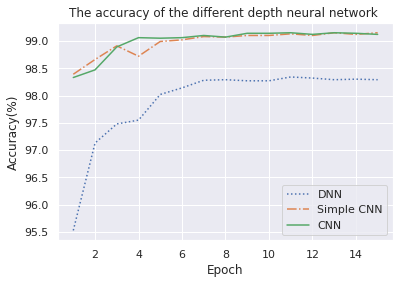

In [18]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

print(accuracys)
x = range(1, epoch_num+1)
plt.figure()
y1 = accuracys[0]
y2 = accuracys[1]
y3 = accuracys[2]
plt.plot(x, y1, label='DNN', linestyle='dotted')
plt.plot(x, y2, label='Simple CNN', linestyle='dashdot')
plt.plot(x, y3, label='CNN')
plt.yticks()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.title('The accuracy of the different depth neural network')
plt.show()

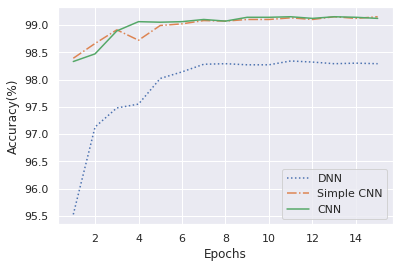

In [20]:
x = range(1, epoch_num+1)
plt.figure()
y1 = accuracys[0]
y2 = accuracys[1]
y3 = accuracys[2]
plt.plot(x, y1, label='DNN', linestyle='dotted')
plt.plot(x, y2, label='Simple CNN', linestyle='dashdot')
plt.plot(x, y3, label='CNN')
plt.yticks()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
# plt.title('The accuracy of the different depth neural network')
plt.show()